# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [34]:
# Standard Libraries
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
from scipy.stats import randint

# Kagglehub (
import kagglehub

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D,
    RandomFlip, RandomRotation, RandomZoom,
    RandomContrast, RandomTranslation,RandomBrightness
)
from tensorflow.keras.applications import  EfficientNetB0
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# The Dataset
> ***Brief Description:***  
  Problem Statement:
  The aim of this project is to classify artworks based on their visual characteristics into various art styles or movements, such as Impressionism, Realism, and Cubism. This supports better digital organization, automatic tagging, and cultural heritage preservation.

  Dataset Description:
  We use the WikiArt - Art Movements/Styles dataset (https://www.kaggle.com/datasets/sivarazadi/wikiart-art-movementsstyles), which contains thousands of paintings labeled according to their artistic styles.

  In this project, I processed the raw image files myself, converting each image into a numerical array format suitable for machine learning. This involved resizing the images, normalizing pixel values, and transforming them into structured input data for model training. These extracted features serve as the foundation for training classification models capable of predicting the style of a given artwork based on its visual content.


In [13]:
# Download dataset
folders_path = kagglehub.dataset_download("sivarazadi/wikiart-art-movementsstyles")
print("folders downloaded to:", folders_path)


folders downloaded to: /kaggle/input/wikiart-art-movementsstyles


Displaying classes that my models will be predicting

In [14]:
path = "/kaggle/input/wikiart-art-movementsstyles"

# List all files in the directory
for file in os.listdir(path):
    print(file)


Academic_Art
Western_Medieval
Symbolism
Neoclassicism
Renaissance
Rococo
Japanese_Art
Art_Nouveau
Baroque
Expressionism
Romanticism
Primitivism
Realism


Processing my images and labelling them accordingly for classical machine learning model

In [15]:
def load_wikiart_images(
    base_path,
    image_size=(128, 128),
    flatten=True,
    max_images_per_class=500
):
    X = []
    y = []

    print("📦 Loading images...")

    for label, folder in enumerate(sorted(os.listdir(base_path))):
        outer_folder_path = os.path.join(base_path, folder)
        if not os.path.isdir(outer_folder_path):
            continue

        inner_folders = os.listdir(outer_folder_path)
        for inner_folder in inner_folders:
            inner_folder_path = os.path.join(outer_folder_path, inner_folder)
            if not os.path.isdir(inner_folder_path):
                continue

            image_count = 0

            for file in tqdm(os.listdir(inner_folder_path), desc=f"{folder}"):
                if image_count >= max_images_per_class:
                    break

                file_path = os.path.join(inner_folder_path, file)
                try:
                    img = Image.open(file_path).convert("RGB")
                    img = img.resize(image_size)
                    img_array = np.array(img)

                    if flatten:
                        img_array = img_array.flatten()

                    X.append(img_array)
                    y.append(label)
                    image_count += 1

                except Exception as e:
                    print(f"⚠️ Error loading {file_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    return X, y


In [ ]:

X, y = load_wikiart_images(path, flatten=True)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


📦 Loading images...


Western_Medieval:  43%|████▎     | 500/1158 [00:58<01:16,  8.55it/s]


Shape of X: (6500, 49152)
Shape of y: (6500,)


Splitting my data  for classical machine learning for classical machine learning model

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (4550, 49152) (4550,)
Validation set: (975, 49152) (975,)
Test set: (975, 49152) (975,)


# SECTION 0: IMPLEMENTING CLASSICAL MACHINE LEARNING(Random Forest)

In [ ]:
os.makedirs('saved_models', exist_ok=True)

X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, train_size=0.3, stratify=y_train, random_state=42
)

pipe_rf = Pipeline([
    ('pca', PCA()),
    ('clf', RandomForestClassifier(random_state=42))
])


param_dist_rf = {
    'pca__n_components': [50, 100, 150],
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

# Randomized search
random_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("🔍 Fast hyperparameter tuning with PCA + RandomizedSearchCV...")
random_search_rf.fit(X_train_small, y_train_small)

# Best model
best_rf_model = random_search_rf.best_estimator_
print("✅ Best RF Hyperparameters (with PCA):", random_search_rf.best_params_)

# Evaluate on validation set
y_val_pred_rf = best_rf_model.predict(X_val)
print("\n📊 RF Evaluation on Validation Set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Precision (macro):", precision_score(y_val, y_val_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_val, y_val_pred_rf, average='macro'))
print("F1 Score (macro):", f1_score(y_val, y_val_pred_rf, average='macro'))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_rf))

# Save the model
model_path_rf = 'saved_models/tuned_random_forest_pca_model.joblib'
joblib.dump(best_rf_model, model_path_rf)
print(f"💾 Best RF model with PCA saved to: {model_path_rf}")

🔍 Fast hyperparameter tuning with PCA + RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best RF Hyperparameters (with PCA): {'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 137, 'pca__n_components': 100}

📊 RF Evaluation on Validation Set:
Accuracy: 0.23794871794871794
Precision (macro): 0.24046705709141417
Recall (macro): 0.23794871794871794
F1 Score (macro): 0.23149112175753117

Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.13      0.14        75
           1       0.31      0.35      0.33        75
           2       0.18      0.23      0.20        75
           3       0.23      0.13      0.17        75
           4       0.32      0.39      0.35        75
           5       0.47      0.43      0.45        75
           6       0.32      0.15      0.20        75
           7       0.16      0.21      0.18        75
           8   

#SECTION 1: Model Architecture:

<img src="https://drive.google.com/uc?export=view&id=1kV5QSyktQeF2xcbBe5fWqn5wf2jRRlfP" alt="Model Architecture">






#Task: Define a function that creates models without and With specified Optimization techniques


Processing images and labelling them accordingly for Neural Network model

In [16]:
X, y = load_wikiart_images(path, image_size=(224, 224), flatten=False, max_images_per_class=500)

X = np.array(X).astype('float32')

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

del X_temp, y_temp
del X

from tensorflow.keras.applications.efficientnet import preprocess_input
X_train = preprocess_input(X_train.astype('float32'))
X_val = preprocess_input(X_val.astype('float32'))
X_test = preprocess_input(X_test.astype('float32'))
print(X_train)
print(X_val)
print(X_test)


📦 Loading images...


Western_Medieval:  43%|████▎     | 500/1158 [00:56<01:14,  8.88it/s]


[[[[176. 185. 176.]
   [177. 185. 178.]
   [186. 193. 188.]
   ...
   [ 60.  78.  59.]
   [ 55.  76.  54.]
   [ 64.  86.  59.]]

  [[176. 185. 180.]
   [179. 188. 184.]
   [186. 195. 192.]
   ...
   [ 64.  83.  65.]
   [ 58.  78.  60.]
   [ 64.  83.  62.]]

  [[174. 183. 184.]
   [183. 193. 193.]
   [172. 182. 182.]
   ...
   [ 63.  84.  69.]
   [ 63.  82.  67.]
   [ 66.  84.  65.]]

  ...

  [[156. 166. 107.]
   [153. 158.  97.]
   [161. 162. 102.]
   ...
   [162. 173. 143.]
   [155. 166. 135.]
   [148. 159. 127.]]

  [[152. 162.  96.]
   [164. 169. 102.]
   [172. 171. 108.]
   ...
   [163. 173. 144.]
   [158. 169. 136.]
   [153. 164. 129.]]

  [[145. 149.  78.]
   [151. 156.  89.]
   [160. 162. 100.]
   ...
   [155. 165. 139.]
   [155. 165. 136.]
   [156. 167. 137.]]]


 [[[ 40.  35.  36.]
   [ 36.  34.  35.]
   [ 34.  36.  35.]
   ...
   [ 35.  35.  35.]
   [ 35.  35.  37.]
   [ 34.  34.  36.]]

  [[  3.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [  0.   0.   0.]
 

Defining a function helping to build CNN using Transfer learning(EfficientNetB0)

In [22]:
def define_model(
    optimizer_name="adam",
    learning_rate=None,
    regularizer=None,
    reg_strength=0.001,
    dropout_rate=0.5,
    use_early_stopping=False,
    epochs=15,
    batch_size=8,
    model_name="my_model.keras"
):
    print(f"\n🔧 Starting new training with EfficientNetB0 base (input: 224x224)...")

    # Optimizer selection
    opt_name = optimizer_name.lower()
    if learning_rate:
        if opt_name == "adam":
            optimizer = Adam(learning_rate=learning_rate)
        elif opt_name == "rmsprop":
            optimizer = RMSprop(learning_rate=learning_rate)
        elif opt_name == "adagrad":
            optimizer = Adagrad(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")
    else:
        if opt_name == "adam":
            optimizer = Adam()
        elif opt_name == "rmsprop":
            optimizer = RMSprop()
        elif opt_name == "adagrad":
            optimizer = Adagrad()

    # Regularization
    if regularizer == "l1":
        reg = l1(reg_strength)
    elif regularizer == "l2":
        reg = l2(reg_strength)
    elif regularizer == "l1_l2":
        reg = l1_l2(l1=reg_strength, l2=reg_strength)
    else:
        reg = None

    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.15),
        RandomZoom(0.2),
        RandomContrast(0.1),
        RandomBrightness(0.2),
    ])

    # Base model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = True
    fine_tune_at = 200
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Full model
    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(13, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = []
    if use_early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Plots
    plt.figure(figsize=(12, 4))
    plt.suptitle("📊 Training Curves")

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # Evaluate on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    prec = precision_score(y_test, y_pred_classes, average='macro')
    rec = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    print("\n🧪 Test Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Save model
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, model_name)
    model.save(save_path)
    print(f"\n📁 Model saved to: {save_path}")

    return {
        "model": model,
        "history": history,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }


🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 445s 744ms/step - accuracy: 0.2716 - loss: 2.2389 - val_accuracy: 0.4513 - val_loss: 1.6804
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 464s 784ms/step - accuracy: 0.4270 - loss: 1.7905 - val_accuracy: 0.5190 - val_loss: 1.6173
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 503s 787ms/step - accuracy: 0.4651 - loss: 1.6286 - val_accuracy: 0.5087 - val_loss: 1.5389
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 503s 789ms/step - accuracy: 0.4902 - loss: 1.5276 - val_accuracy: 0.5610 - val_loss: 1.4403
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 499s 784ms/step - accuracy: 0.5441 - loss: 1.4453 - val_accuracy: 0.5374 - val_loss: 1.5520
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 504s 787ms/step - accuracy: 0.5618 - loss: 1.3737 - val_accuracy: 0.5703 - val_loss: 1.4165
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 502s 787ms/step - accuracy: 0.5674 - loss: 1.31

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


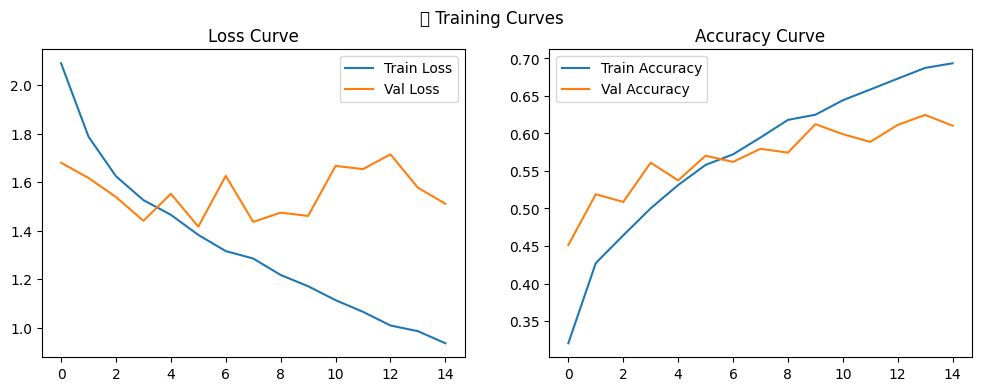

31/31 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

🧪 Test Evaluation:
Accuracy:  0.6092
Precision: 0.6220
Recall:    0.6092
F1 Score:  0.6108

📁 Model saved to: saved_models/model_1.keras


In [18]:
cnn_notuning= define_model(model_name="model_1.keras")

In [39]:
cnn_notuning["model"].summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,647,916 (32.99 MB)

 Trainable params: 2,216,349 (8.45 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

 Optimizer params: 4,432,700 (16.91 MB)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose


🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 470s 792ms/step - accuracy: 0.2271 - loss: 2.7618 - val_accuracy: 0.4882 - val_loss: 1.9706
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 499s 787ms/step - accuracy: 0.4044 - loss: 2.1940 - val_accuracy: 0.5056 - val_loss: 1.8823
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 501s 785ms/step - accuracy: 0.4760 - loss: 1.9430 - val_accuracy: 0.5631 - val_loss: 1.6372
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 502s 785ms/step - accuracy: 0.5254 - loss: 1.7493 - val_accuracy: 0.5836 - val_loss: 1.5243
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 503s 787ms/step - accuracy: 0.5417 - loss: 1.6329 - val_accuracy: 0.5662 - val_loss: 1.5679
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 499s 782ms/step - accuracy: 0.5609 - loss: 1.5811 - val_accuracy: 0.5990 - val_loss: 1.5584
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 504s 786ms/step - accuracy: 0.5934 - loss: 1.4556 - val_accuracy: 0.5979 - val_loss: 1.5868


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


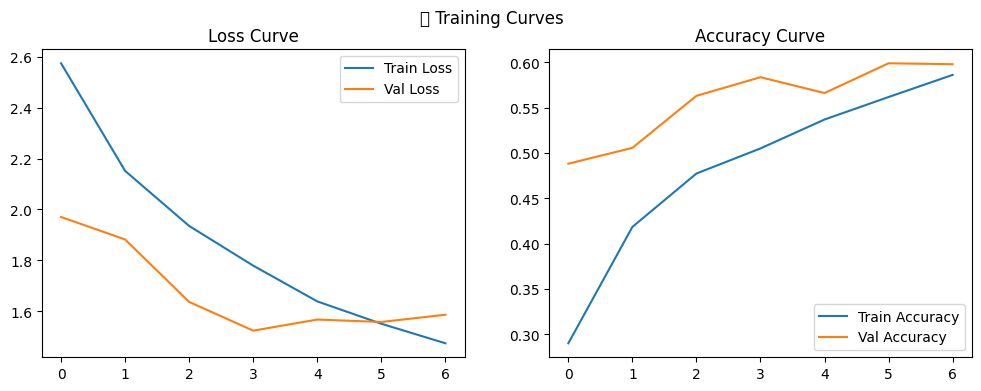

31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step

🧪 Test Evaluation:
Accuracy:  0.5918
Precision: 0.5901
Recall:    0.5918
F1 Score:  0.5821

📁 Model saved to: saved_models/model_2.keras


In [19]:
#TODO:
model_2 =define_model(
    optimizer_name='adam',
    learning_rate=0.0005,
    regularizer='l2',
    reg_strength=0.002,
    dropout_rate=0.6,
    use_early_stopping=True,
    batch_size=8,
    epochs=15,
    model_name="model_2.keras"
)



🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 488s 830ms/step - accuracy: 0.1632 - loss: 5.0637 - val_accuracy: 0.4205 - val_loss: 4.2953
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 493s 814ms/step - accuracy: 0.3581 - loss: 4.3331 - val_accuracy: 0.4964 - val_loss: 3.7798
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 436s 766ms/step - accuracy: 0.4479 - loss: 3.8313 - val_accuracy: 0.5282 - val_loss: 3.4516
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 478s 830ms/step - accuracy: 0.4904 - loss: 3.5049 - val_accuracy: 0.5579 - val_loss: 3.1812
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 500s 827ms/step - accuracy: 0.4985 - loss: 3.2773 - val_accuracy: 0.5744 - val_loss: 2.9790
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 507s 836ms/step - accuracy: 0.5267 - loss: 3.0113 - val_accuracy: 0.5867 - val_loss: 2.7712
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 470s 825ms/step - accuracy: 0.5614 - loss: 2.7524 - val_accuracy: 0.5949 - val_loss: 2.5974
Epoch 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


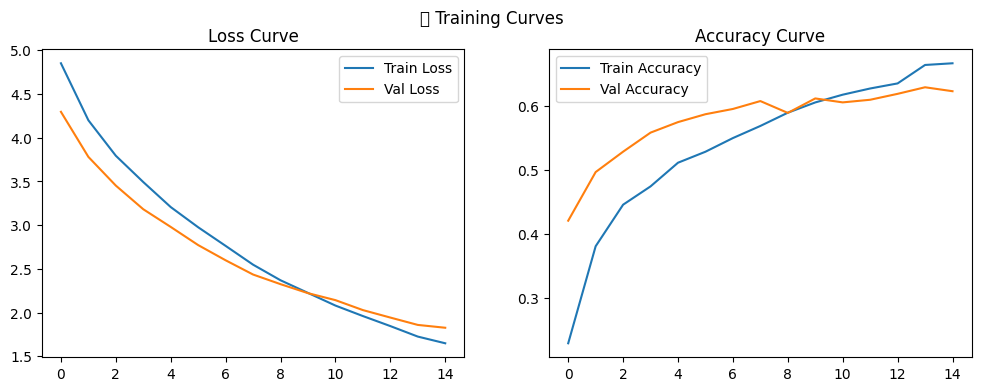

31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step

🧪 Test Evaluation:
Accuracy:  0.6379
Precision: 0.6394
Recall:    0.6379
F1 Score:  0.6322

📁 Model saved to: saved_models/model_3.keras


In [20]:
#TODO:
model_3 = define_model(
    optimizer_name="rmsprop",
    learning_rate=1e-4,
    regularizer="l1",
    reg_strength=0.0005,
    dropout_rate=0.4,
    use_early_stopping=True,
    epochs=15,
    batch_size=8,
    model_name="model_3.keras"
)


🔧 Starting new training with EfficientNetB0 base (input: 224x224)...
Epoch 1/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.1586 - loss: 7.6671 - val_accuracy: 0.3959 - val_loss: 6.0830
Epoch 2/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.3757 - loss: 5.7789 - val_accuracy: 0.4779 - val_loss: 4.6963
Epoch 3/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.4264 - loss: 4.5531 - val_accuracy: 0.5221 - val_loss: 3.7296
Epoch 4/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.4804 - loss: 3.6410 - val_accuracy: 0.5385 - val_loss: 3.0213
Epoch 5/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.4995 - loss: 2.9994 - val_accuracy: 0.5508 - val_loss: 2.5337
Epoch 6/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.5115 - loss: 2.5623 - val_accuracy: 0.5497 - val_loss: 2.2226
Epoch 7/12
285/285 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.5265 - loss: 2.2775 - val_accuracy: 0.5703 - val_loss: 2.0088
Epoch 8/12
285/285 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


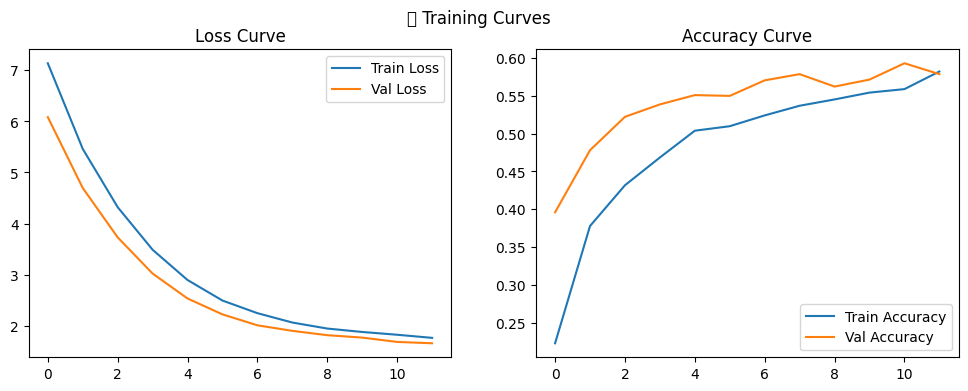

31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step

🧪 Test Evaluation:
Accuracy:  0.5826
Precision: 0.5765
Recall:    0.5826
F1 Score:  0.5752

📁 Model saved to: saved_models/model_4.keras


In [24]:
model_adagrad = define_model(
    optimizer_name="adagrad",
    learning_rate=0.01,
    regularizer="l1_l2",
    reg_strength=0.001,
    dropout_rate=0.5,
    use_early_stopping=True,
    batch_size=16,
    epochs=12,
    model_name="model_4.keras"
)


In [25]:
!zip -r saved_models.zip saved_models


  adding: saved_models/ (stored 0%)
  adding: saved_models/model_4.keras (deflated 13%)
  adding: saved_models/model_1.keras (deflated 10%)
  adding: saved_models/model_2.keras (deflated 10%)
  adding: saved_models/.ipynb_checkpoints/ (stored 0%)
  adding: saved_models/model_3.keras (deflated 11%)


In [26]:
from google.colab import files
files.download("saved_models.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Defining class labels

In [27]:
class_names = [
    "Primitivism", "Japanese_Art", "Romanticism", "Baroque",
    "Academic_Art", "Western_Medieval", "Symbolism", "Art_Nouveau",
    "Realism", "Rococo", "Expressionism", "Renaissance", "Neoclassicism"
]


Evaluation function

In [29]:
def evaluate_model(model_obj, model_name):
    y_probs = model_obj["model"].predict(X_test)
    y_preds = np.argmax(y_probs, axis=1)

    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(12, 10))
    disp.plot(xticks_rotation=45, cmap="Blues", values_format="d")
    plt.title(f"📊 Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    f1 = f1_score(y_test, y_preds, average='macro')
    print(f"🧪 F1 Score for {model_name}: {f1:.4f}")



📊 Evaluating model_1...
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


/tmp/ipython-input-29-19484403.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


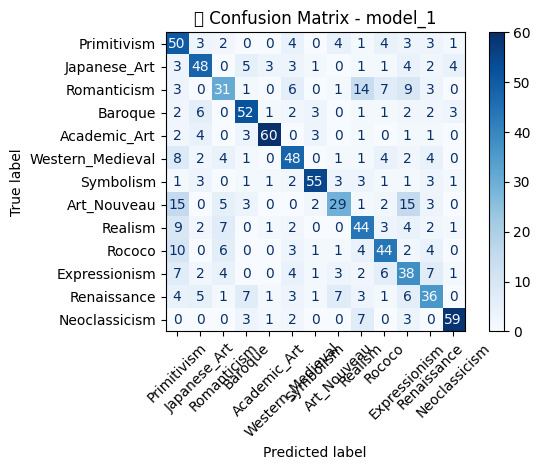

🧪 F1 Score for model_1: 0.6108

📊 Evaluating model_2...
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step


/tmp/ipython-input-29-19484403.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


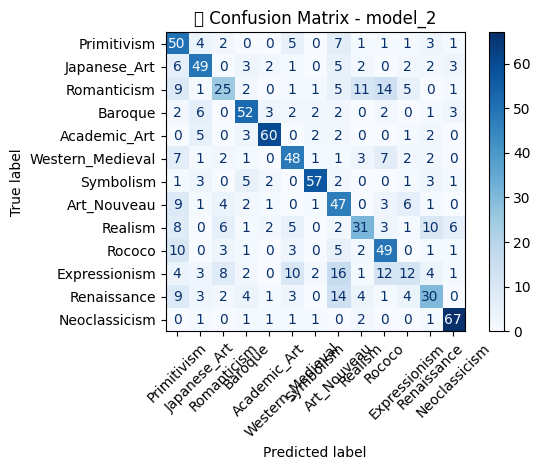

🧪 F1 Score for model_2: 0.5821

📊 Evaluating model_3...
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


/tmp/ipython-input-29-19484403.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


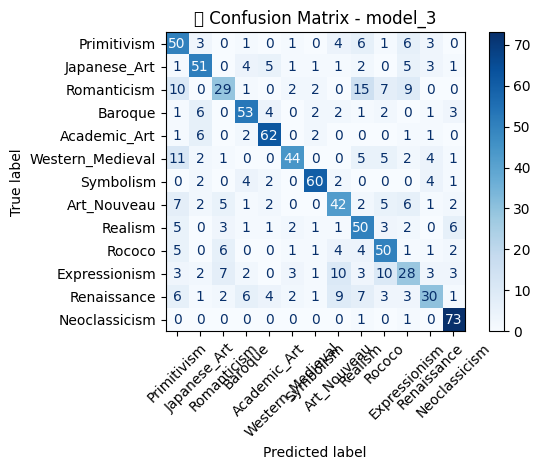

🧪 F1 Score for model_3: 0.6322

📊 Evaluating model_4...
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step


/tmp/ipython-input-29-19484403.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


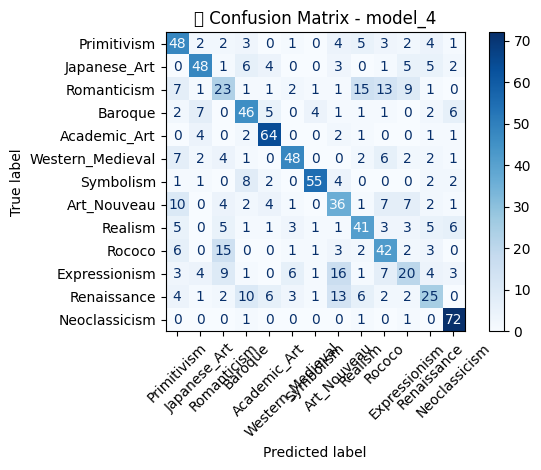

🧪 F1 Score for model_4: 0.5752


In [33]:
models= {
    "model_1": cnn_notuning,
    "model_2": model_2,
    "model_3": model_3,
    "model_4": model_adagrad
}
# Loop to evaluate and show confusion matrices
for name, model_dict in models.items():
    print(f"\n📊 Evaluating {name}...")
    evaluate_model(model_dict, name)


Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [36]:
def make_predictions(model_path, X):
    model = load_model(model_path)
    probas = model.predict(X)
    predictions = np.argmax(probas, axis=1)

    return predictions

In [37]:
X_sample = X_test
predictions = make_predictions("saved_models/model_3.keras", X_test)
print(predictions[:10])


31/31 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
[ 7  2  9  8 10 12  8  7  4  5]


In [38]:
label_preds = [class_names[i] for i in predictions]
print(label_preds[:10])


['Art_Nouveau', 'Romanticism', 'Rococo', 'Realism', 'Expressionism', 'Neoclassicism', 'Realism', 'Art_Nouveau', 'Academic_Art', 'Western_Medieval']


Congratulations!!
